In [1]:
from brian2 import *
from util.visualization_functions import *
from util.analysis_functions import *
%matplotlib inline
# prefs.codegen.target = "numpy" # delete if get c++ build tools working
# set_device('cpp_standalone', directory='plaground') # for C speedup


In [ ]:
# trying to recreate the simulation used in Ocker 2015

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2 # leak conductance
vL = -72 * mV               # leak reversal potential
C = 1 * ufarad * cm**-2     # membrane capacitance
delta = 1.4 * mV            # action potential steepness
vT = -48 * mV               # action potential initiation threshold
mu = 1 * uamp * cm**-2      # noise mean
sigma = 9 * mV              # noise std dev

# other cell params
vTh = 30 * mV               # spike threshold
vR = -72 * mV               # reset potential
tRef = 2 * ms               # action potential width (refractory time)

# network params
p = 0.15                    # connection density
N = 100                     # number of neurons

# stdp params
wMax = 5 / N / p * uamp * cm**-2    # max syn weight - TODO: generate wMax from connectivity stats like in paper?
tauPre = 5 * ms #15 * ms            # synaptic time constant
tauPost = 5 * ms #2 * tauPre        # synaptic time constant
dApost = -wMax / 5 / N              # f neg (f post)
dApre = -dApost * tauPost / tauPre  # f pos (f pre)

# model
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi)) / C : volt (unless refractory)
'''

G = NeuronGroup(N, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

S = Synapses(G, G,
             '''w : amp * meter**-2
                dApre/dt = -Apre / tauPre : amp * meter**-2 (event-driven)
                dApost/dt = -Apost / tauPost : amp * meter**-2 (event-driven)''',
             on_pre='''v += w * v * cm**2 * amp**-1
                    Apre += dApre
                    w = clip(w + Apost, 0, wMax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, wMax)'''
            )
           
# TODO: initialize mean weight over some distribution?
S.connect(condition='i!=j', p=p)
S.w = 'wMax * rand() / 3'

# monitors
v_mon = StateMonitor(G, 'v', record=True)
sp_mon_exc = SpikeMonitor(G)
w_mon = StateMonitor(S, 'w', record = True)

# initial value
#G.v = 5 * mV 

# initial stats
(p0, q_div0, q_con0, q_ch0, q_rec0) = compute_motif_stats(G, S)

# run
run(1000*ms, report='text')

# final stats
(p, q_div, q_con, q_ch, q_rec) = compute_motif_stats(G, S)

# plots
#visualise_connectivity(S)
plot_v(v_mon, sp_mon_exc, 0, True)
plot_spike_trains(sp_mon_exc)


print("p: " + str(p0) + "-->" + str(p))
print("q_div: " + str(q_div0) + "-->" + str(q_div))
print("q_con: " + str(q_con0) + "-->" + str(q_con))
print("q_ch: " + str(q_ch0) + "-->" + str(q_ch))
print("q_rec: " + str(q_rec0) + "-->" + str(q_rec))





WARNING    "w" is an internal variable of group "synapses", but also exists in the run namespace with the value 50000. * amp * meter ** -2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "v" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 270. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "v" is an internal variable of group "synapses", but also exists in the run namespace with the value 270. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 8 lines of abstract code, first line is: "_Apost := Apost * exp(_lio_1 * (- (t - lastupdate))) (constant)"
 [bria

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s


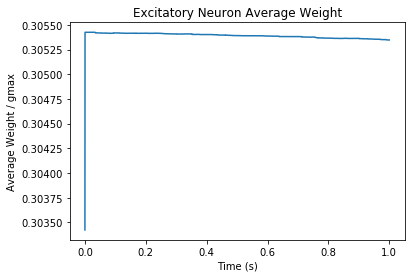

In [3]:
avg_w_e = w_mon.w.mean(axis=0)
plot(w_mon.t/second, avg_w_e/wMax)
title('Excitatory Neuron Average Weight')
xlabel('Time (s)')
ylabel('Average Weight / gmax')
plt.show()

In [4]:
# motif stats
from util.analysis_functions import *

network_group = G
synapses = S

N = len(network_group)
W = np.zeros((N, N))

# Insert the values from the Synapses object
W[synapses.i[:], synapses.j[:]] = synapses.w[:]

# motif stats...
p = W.sum() / N**2

q_div = 0
for i in range(N):
    for j in range(N):
        for k in range(N):
            q_div += W[i,k] * W[j,k]

q_div = (q_div - p**2) / N**3

print(q_div)

0.00023713054966151975


-1.e-05 m^-2 A
30. ms
-3.e-07 C/m^2


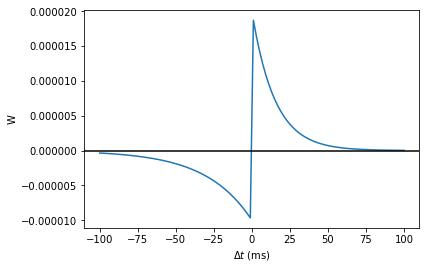

In [5]:
from brian2.units import *

# stdp params
wMax = 5 * uamp * cm**-2    # max syn weight
tauPre = 15 * ms            # synaptic time constant
tauPost = 2 * tauPre        # synaptic time constant
dApost = -wMax / 5000       # f neg (f post)

print(dApost)
print(tauPost)
print(dApost * tauPost)

dApre = -dApost * tauPost / tauPre # f pos (f pre)

# plot
visualize_stdp(dApre, tauPre, dApost, tauPost)

-6.7e-06
30. ms
-201. ns
-6.7e-07


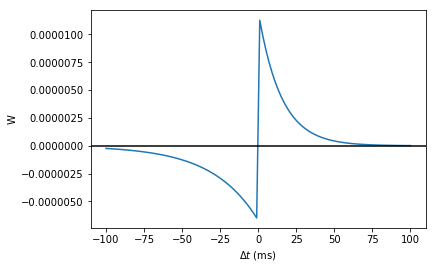

In [6]:
# dimensionless stdp params
wMax = 0.0335               # max syn weight
deleps = -wMax / 50000      # ???
tauPre = 15 * ms            # synaptic time constant
tauPost = 2 * tauPre        # synaptic time constant
dApost = -wMax / 5000       # f neg (f post)

print(dApost)
print(tauPost)
print(dApost * tauPost)

print(deleps)

dApre = (-dApost * tauPost + deleps * tauPost) / tauPre # f pos (f pre)

# plot
visualize_stdp(dApre, tauPre, dApost, tauPost)